# Tutorial - Intuitions about Image Embeddings
#### Author: Antonio Rueda-Toicen
#### [Berlin Computer Vision Group](https://www.meetup.com/berlin-computer-vision-group/)

**antonio.rueda.toicen 'at' gmail 'dot' com**

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

##  Apples, Oranges, Car

In [39]:

# Here's a simple way to get a list of images from urls

import skimage.io as io
from PIL import Image

urls = ['https://github.com/andandandand/image-dataset-curation/blob/main/images/red_apple_1.png?raw=true'
       'https://github.com/andandandand/image-dataset-curation/blob/main/images/red_apple_2.png?raw=true',
        'https://github.com/andandandand/image-dataset-curation/blob/main/images/green_apple_1.png?raw=true',
        'https://github.com/andandandand/image-dataset-curation/blob/main/images/orange_1.png?raw=true',
        'https://github.com/andandandand/image-dataset-curation/blob/main/images/orange_2.png?raw=true',
        'https://github.com/andandandand/image-dataset-curation/blob/main/images/toy_car_2.png?raw=true']

images = [Image.fromarray(io.imread(url)).convert('RGB')for url in urls]


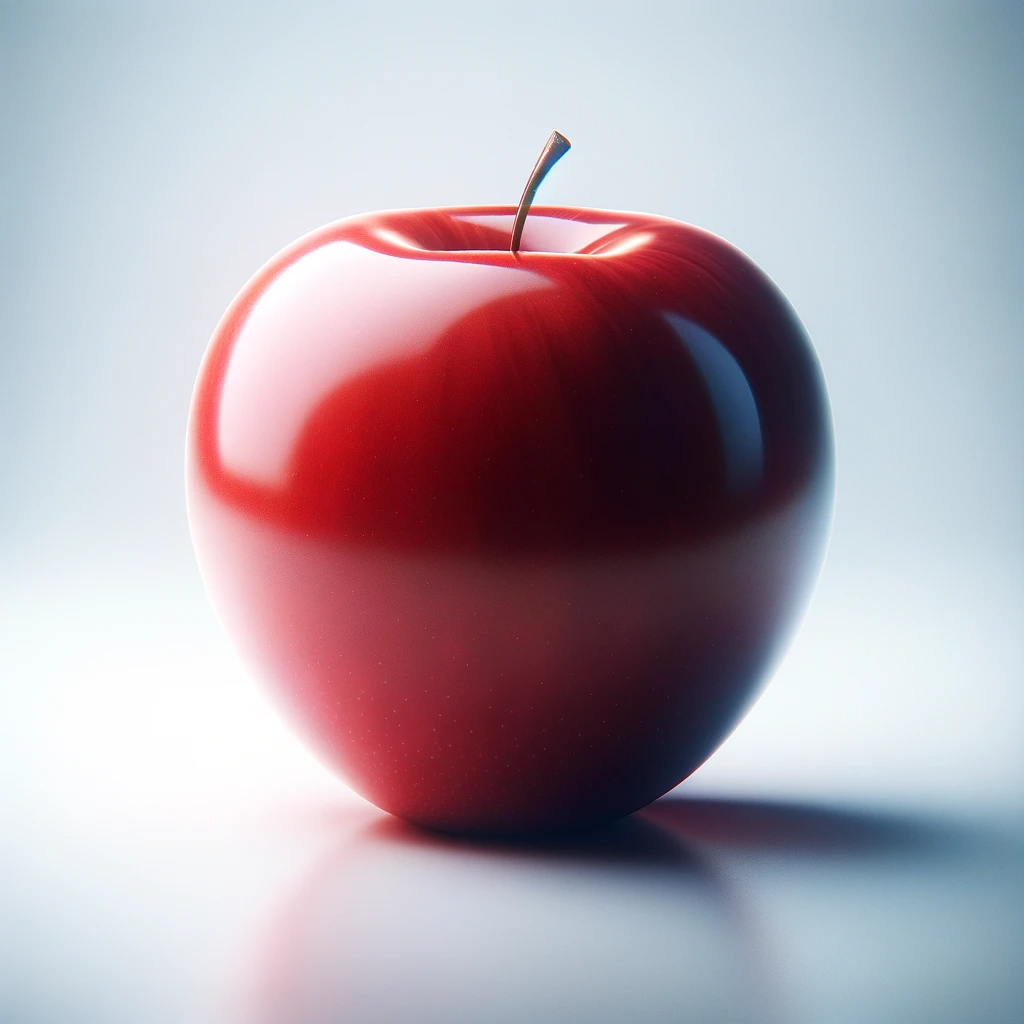

In [40]:
# Some redundancy here, it's helpful to type it :)
url_1 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/red_apple_1.png?raw=true'
img_1 = Image.fromarray(io.imread(url_1)).convert('RGB')
img_1

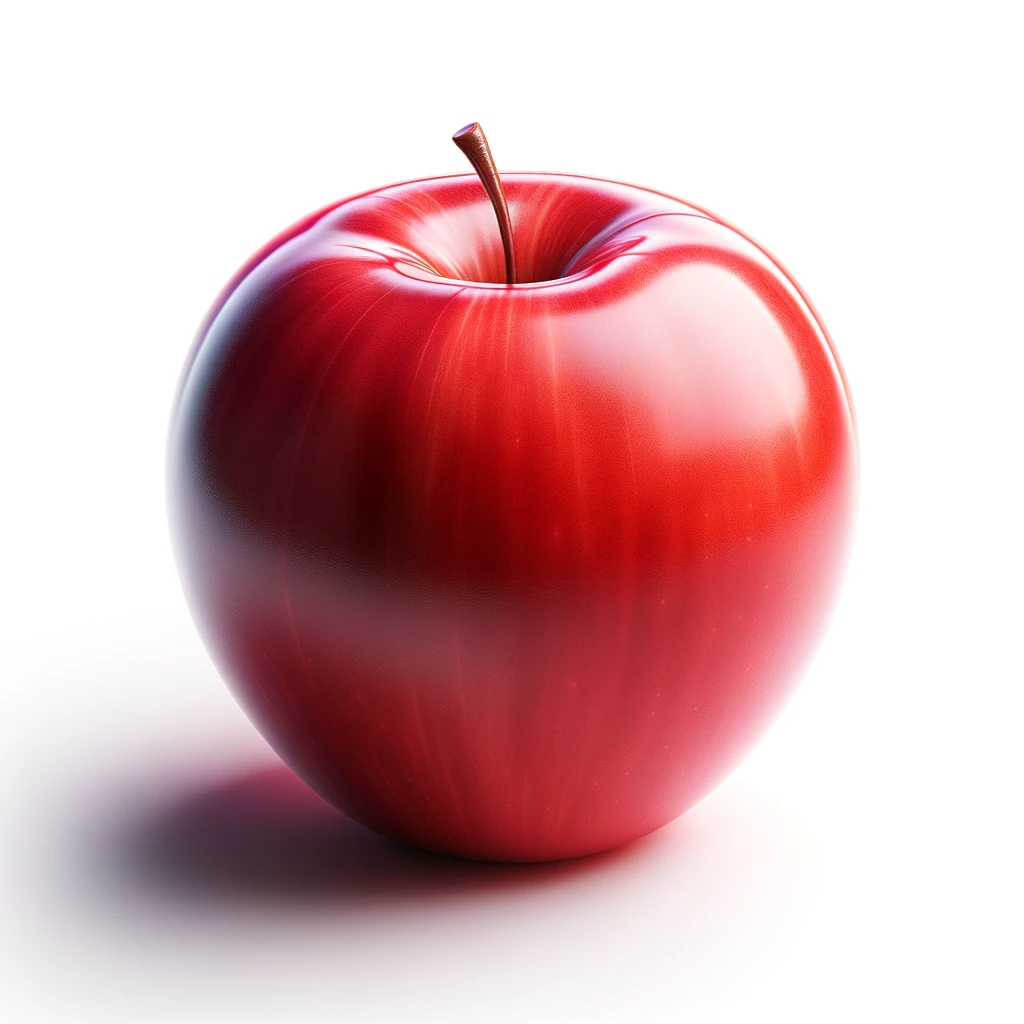

In [41]:
url_2 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/red_apple_2.png?raw=true'
img_2 = Image.fromarray(io.imread(url_2)).convert('RGB')
img_2

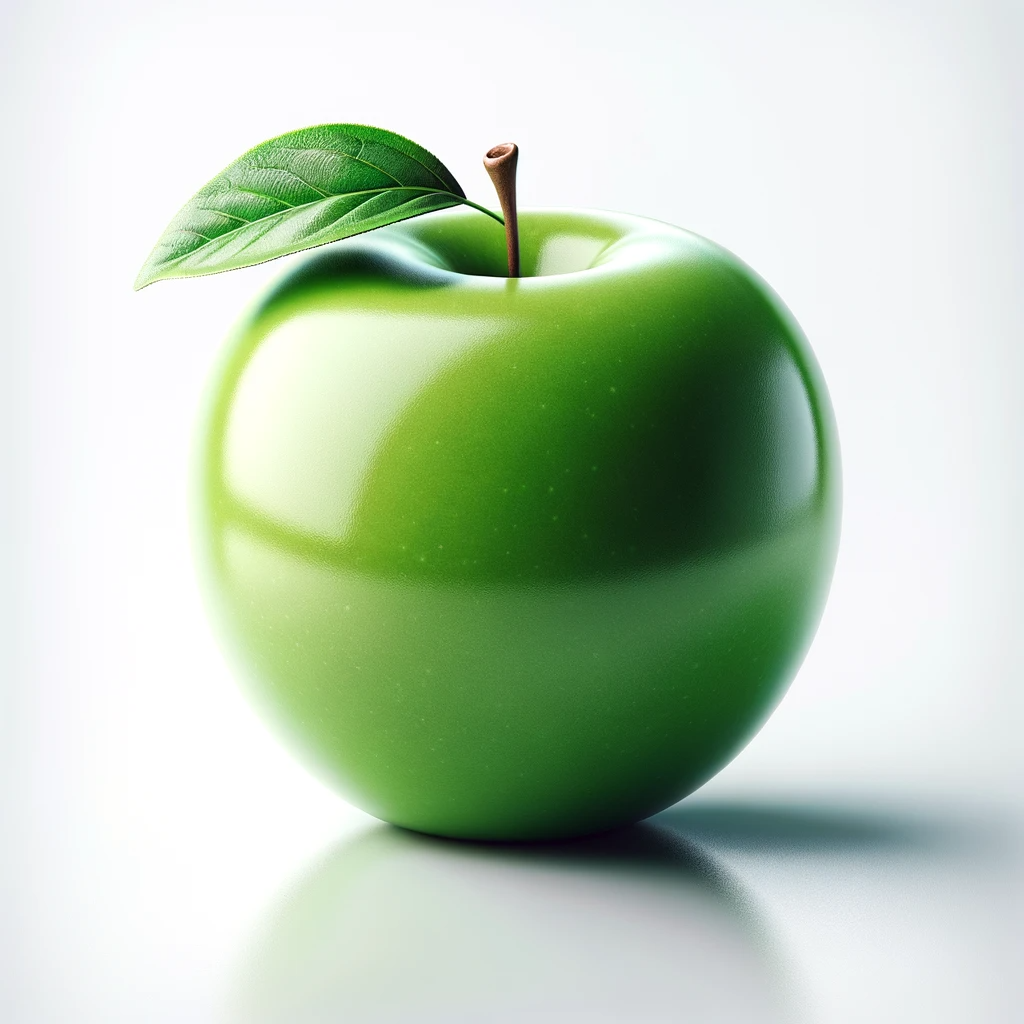

In [42]:
url_3 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/green_apple_1.png?raw=true'
img_3 = Image.fromarray(io.imread(url_3)).convert('')
img_3

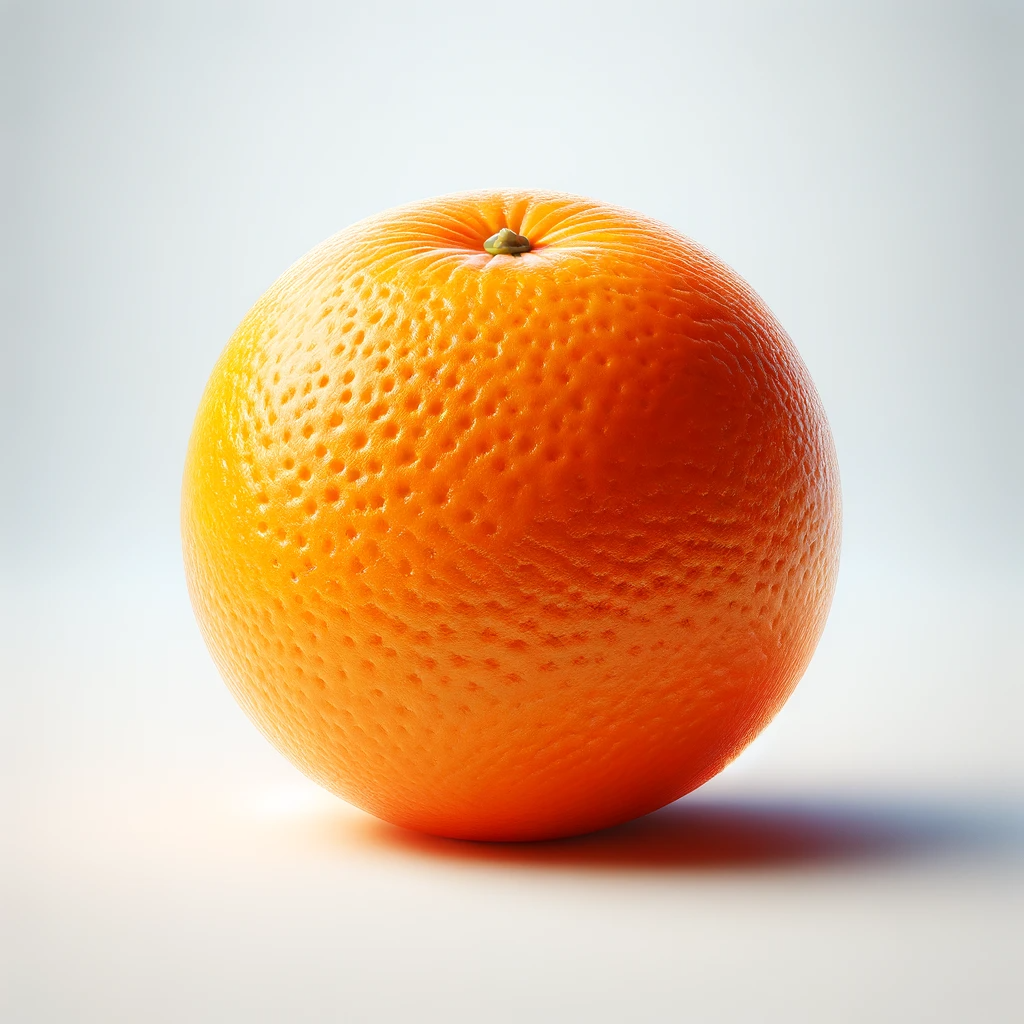

In [43]:
url_4 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/orange_1.png?raw=true'
img_4 = Image.fromarray(io.imread(url_4)).convert('RGB')
img_4

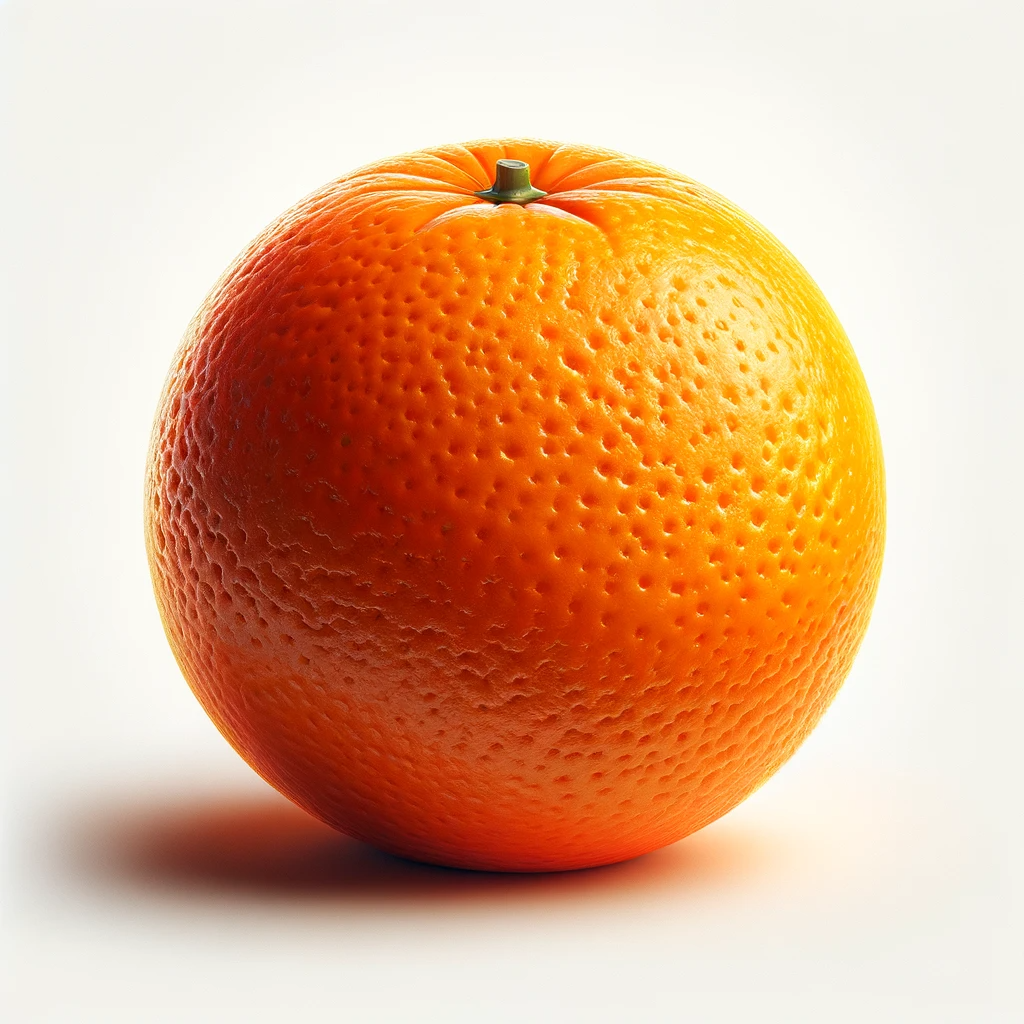

In [44]:
url_5 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/orange_2.png?raw=true'
img_5 = Image.fromarray(io.imread(url_5)).convert('RGB')
img_5

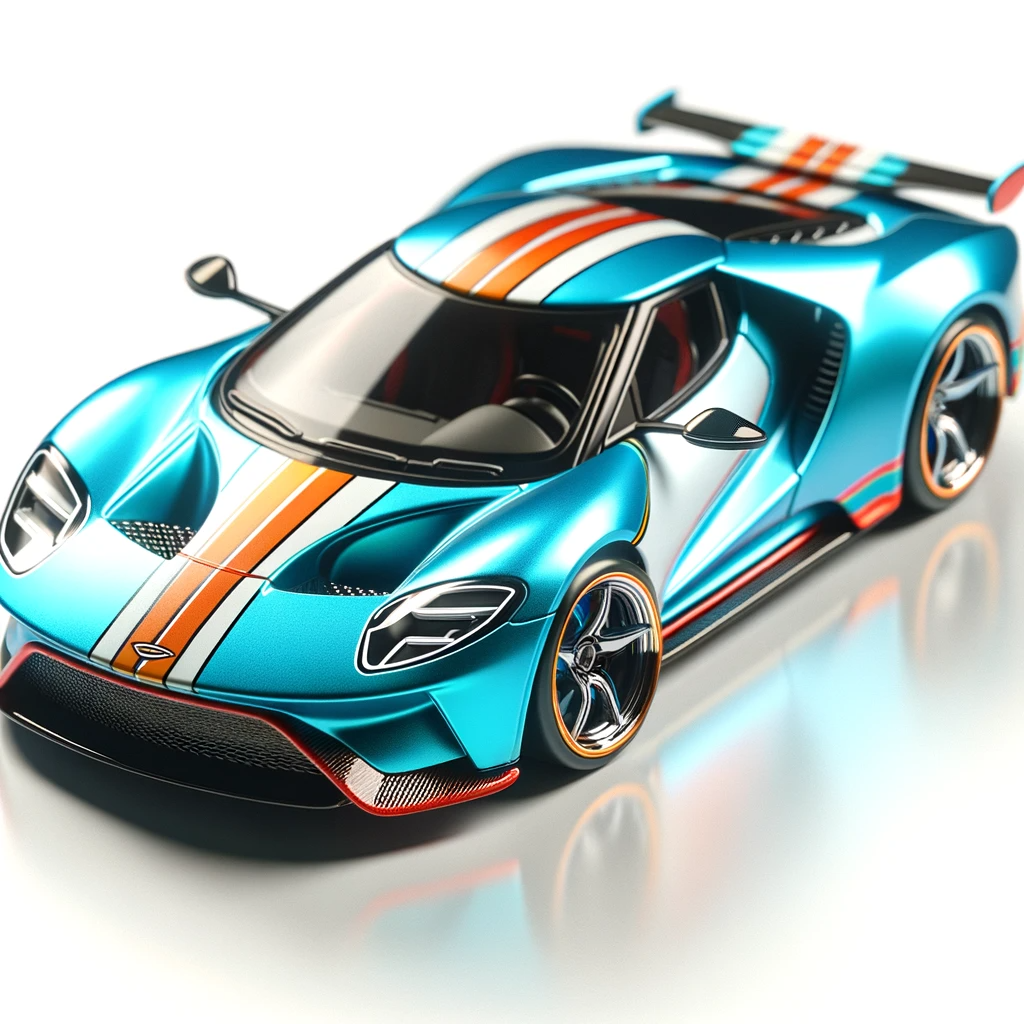

In [45]:
url_6 = 'https://github.com/andandandand/image-dataset-curation/blob/main/images/toy_car_2.png?raw=true'
img_6 = Image.fromarray(io.imread(url_6)).convert('RGB')
img_6

## Pretrained neural network for embedding



In [46]:
# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

## Compare image pairs

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

def print_cosine_similarity(embedding_a, embedding_b):
  cos = cosine_similarity(embedding_a, embedding_b)
  result = f'Cosine similarity = {cos:.2f}'
  print(result)

def show_pair(imag_a, imag_b):
  plt.subplot(121)
  plt.imshow(np.array(imag_a))
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(np.array(imag_b))
  plt.axis("off")

In [48]:
img2vec = Img2Vec()
vec_1 = img2vec.get_vec(img_1)
vec_2 = img2vec.get_vec(img_2)

In [49]:
print_cosine_similarity(vec_1, vec_2)

Cosine similarity = 0.91


In [50]:
embeddings = [img2vec.get_vec(img) for img in images]

Cosine similarity = 0.84


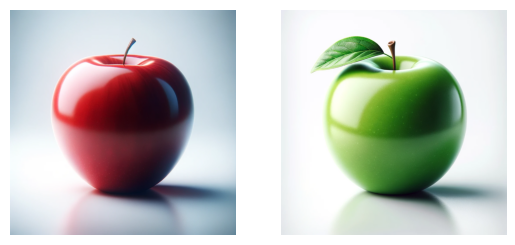

In [51]:
# @title {run:'auto'}


slider_1 = 0  # @param {type: "slider", min: 0, max: 5}

slider_2 = 1  # @param {type: "slider", min: 0, max: 5}
print_cosine_similarity(embeddings[slider_1], embeddings[slider_2])
show_pair(images[slider_1], images[slider_2])